# Introducción


In [1]:
%reset -f
prefix = r"C:\Users\Adrian\Downloads\dataset"

In [2]:
import torch
print("¿GPU disponible para PyTorch?:", torch.cuda.is_available())

import tensorflow as tf
print("¿GPU disponible para TensorFlow?:", len(tf.config.list_physical_devices('GPU')) > 0)

¿GPU disponible para PyTorch?: True
¿GPU disponible para TensorFlow?: True


In [3]:
# Importa librerías necesarias para manipulación de datos, visualización y manejo de imágenes
%matplotlib inline
import gc
import os
import segmentation_models as sm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Importa librerías de TensorFlow y Keras para manejo de modelos y configuración
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, layers

# Imprime la versión de TensorFlow para confirmar la instalación
print("Tensorflow version " + tf.__version__)

# Establece la variable AUTO para optimización automática del procesamiento de datos
AUTO = tf.data.experimental.AUTOTUNE

# Desactiva los mensajes de advertencia de TensorFlow para evitar saturar la consola
import logging
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Desactiva las advertencias generales para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

Segmentation Models: using `keras` framework.
Tensorflow version 2.10.1


In [4]:
# Configura las semillas aleatorias para garantizar la reproducibilidad de los resultados
from tensorflow import random
import random as randm
from numpy.random import seed

def seed_all_inclusive(seeding):
    # Establece las semillas para TensorFlow, NumPy y la aleatoriedad del sistema
    random.set_seed(seeding)
    seed(seeding)
    os.environ['PYTHONHASHSEED'] = str(seeding)
    randm.seed(seeding)

# Define la semilla a usar
seeding = 1
seed_all_inclusive(seeding)


In [5]:
# Parámetros globales de configuración
img_size = 512  # Tamaño de las imágenes de entrada
repeat_epoch = 10  # Número de épocas de repetición
backbone = 'efficientnetb2'  # Backbone del modelo de segmentación MOD JP
zoom_pixel_fixed = img_size // 4  # Parámetro de zoom fijo para las imágenes
global TL_FLAG  # Bandera global para Transfer Learning (por definir su uso)

radiopedia_FLAG = 1  # Bandera para activar el uso del dataset de Radiopedia
batch_size = 16  # Tamaño de batch para entrenar el modelo MOD 1
print('batch size', batch_size)
print('zoom_pixel_fixed.........', zoom_pixel_fixed)

batch size 16
zoom_pixel_fixed......... 128


In [6]:
# Configuración para validación cruzada de 5 pliegues (5-fold validation)
n_split = 5  # Número de pliegues
kfold_index = n_split
skf = KFold(n_splits=n_split, shuffle=True, random_state=seeding)  # Genera los índices para cada pliegue

In [7]:


# Carga los datasets si la bandera de Radiopedia está activada
if radiopedia_FLAG:
    # Carga las imágenes y máscaras del dataset de Radiopedia
    images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
    masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg para pruebas
test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [8]:
# Función para visualizar las imágenes, máscaras y predicciones (opcionalmente)
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        # Muestra la imagen original en la primera fila
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode:
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')  # Muestra la imagen en escala de grises
        else:
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([])  # Elimina los ticks del eje X
        ax_image.set_yticks([])  # Elimina los ticks del eje Y

        # Si existen máscaras, muestra cada clase de máscara en las filas subsiguientes
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]  # Muestra la máscara original
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))  # Muestra la predicción en colores
                    mask_to_show[..., 0] = pred_batch[i,:,:,j].cpu().numpy() > 0.5 # Predicción
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]  # Máscara original
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    # Ajusta el layout para una mejor visualización
    plt.tight_layout()
    plt.show()

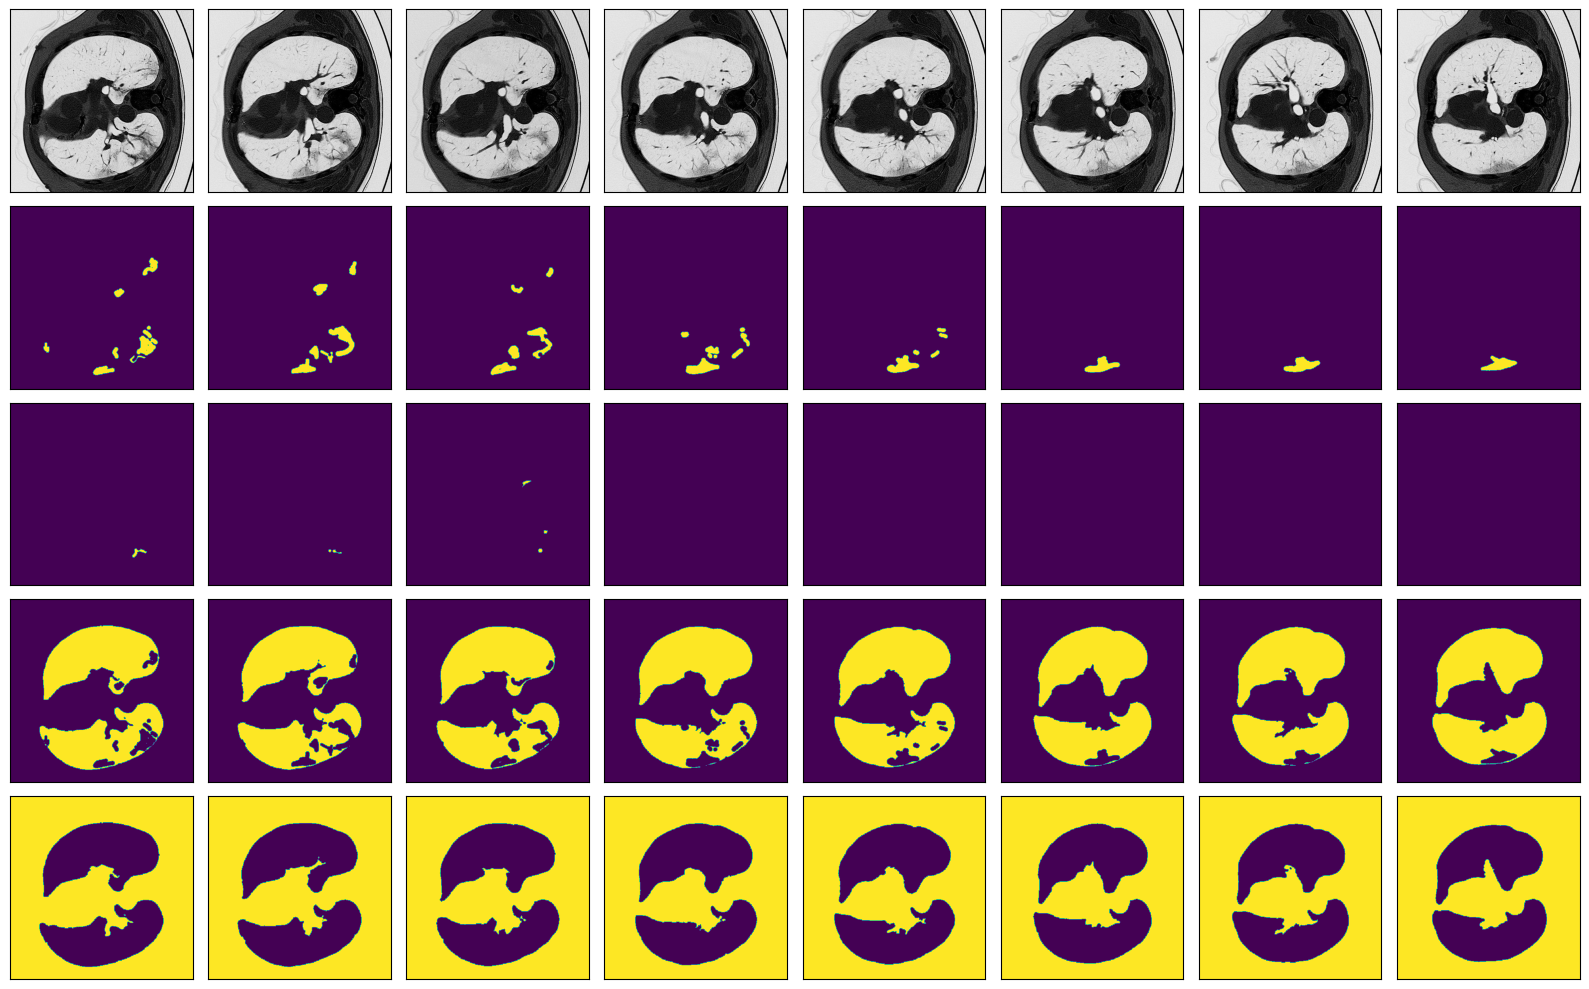

In [9]:
# Visualiza las imágenes de Radiopedia a partir del índice 30 y sus correspondientes máscaras
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


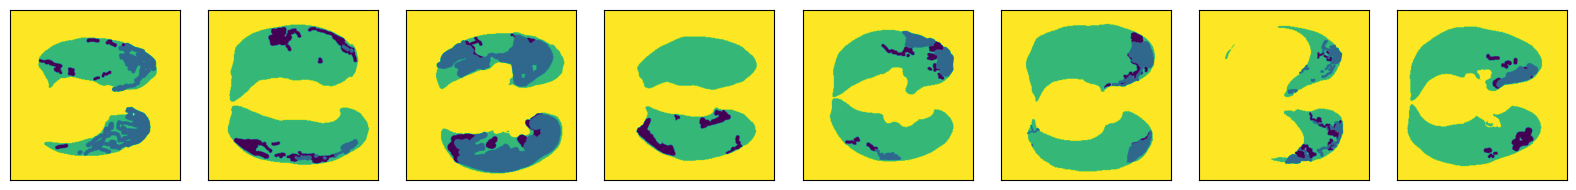

In [10]:
def onehot_to_mask(mask, palette):
    """
    Convierte una máscara codificada one-hot (H, W, K) a una máscara con una paleta de colores (H, W, C).
    """
    # Encuentra el índice del valor máximo a lo largo del eje de canales, para convertir de one-hot a clase
    x = np.argmax(mask, axis=-1)

    # Convierte los índices de las clases en colores usando la paleta
    colour_codes = np.array(palette)

    # Asigna los colores correspondientes a la máscara
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

# Paleta de colores que mapea las clases a valores [0, 1, 2, 3]
palette = [[0], [1], [2], [3]]

# Convierte las máscaras de one-hot encoding a formato paleteado
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Imprime las dimensiones de las máscaras antes y después de la conversión
print('Hot encoded mask size: ', masks_radiopedia.shape)
print('Paletted mask size:', masks_medseg_recover.shape)

# Visualiza las máscaras convertidas (no codificadas en one-hot)
visualize(masks_medseg_recover[30:], hot_encode=False)

In [11]:
def preprocess_images(images_arr, mean_std=None):
    # Limita los valores de los píxeles entre -1500 y 500
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500

    # Calcula los percentiles 5 y 95 de los valores válidos de los píxeles MOD 2
    min_perc, max_perc = np.percentile(images_arr, 2), np.percentile(images_arr, 98)

    # Filtra los valores válidos entre esos percentiles
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]

    # Calcula la media y la desviación estándar si no se ha proporcionado
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std

    # Normaliza la imagen utilizando la media y desviación estándar
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')

    return images_arr, (mean, std)

# Combina los datasets MedSeg y Radiopedia MOD 3
combined_images = np.concatenate([images_medseg, images_radiopedia], axis=0)

# Calcula la media y desviación estándar del dataset combinado
mean_std_combined = (combined_images.mean(), combined_images.std())
print(f'Media global: {mean_std_combined[0]}, Desviación estándar global: {mean_std_combined[1]}')

# Aplica la normalización global a todos los conjuntos de datos
images_radiopedia, _ = preprocess_images(images_radiopedia, mean_std_combined)
images_medseg, _ = preprocess_images(images_medseg, mean_std_combined)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std_combined)

Media global: -449.8793029785156, Desviación estándar global: 495.4303894042969
mean -449.8793029785156, std 495.4303894042969
mean -449.8793029785156, std 495.4303894042969
mean -449.8793029785156, std 495.4303894042969


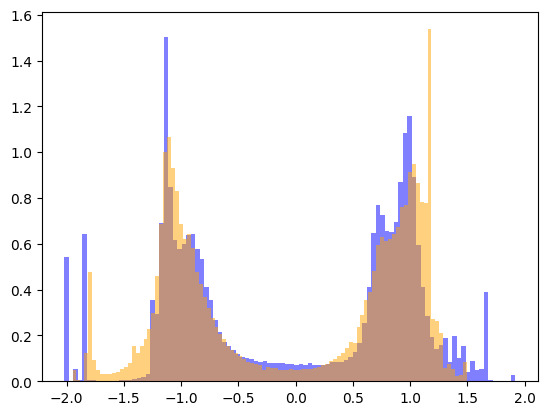

In [12]:
def plot_hists(images1, images2=None):
    # Grafica el histograma de la distribución de valores de las imágenes
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)

    # Si se proporcionan dos conjuntos de imágenes, grafica ambos en el mismo histograma
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

# Grafica los histogramas de las imágenes preprocesadas
plot_hists(test_images_medseg, images_radiopedia)

In [13]:
# Convertir máscaras nuevamente a su formato de colores
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()

# Dividir los índices de las imágenes en conjuntos de validación y entrenamiento
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

# Combina imágenes y máscaras de diferentes conjuntos para entrenamiento
train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))

# Asigna los conjuntos de validación
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

# Tamaño del batch igual al número de máscaras de validación
batch_size = len(val_masks)

# Elimina variables grandes de la memoria para liberar espacio
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

In [14]:
import tensorflow
import albumentations
import cv2

# Dimensiones de origen y destino para las transformaciones de las imágenes
SOURCE_SIZE = 512
TARGET_SIZE = 256

# Definición de las augmentaciones para el conjunto de entrenamiento
train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
                                   TARGET_SIZE,
                                   TARGET_SIZE,
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
])

# Augmentaciones para el conjunto de validación (solo redimensionar)
val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [15]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torch

# Si les da error en esta linea, cambiar el entorno de ejecucion a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Clase Dataset personalizada para cargar imágenes y máscaras
class Dataset:
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        # Cargar una imagen y su máscara correspondiente
        image = self.images[i]
        mask = self.masks[i]

        # Aplicar augmentaciones si están definidas
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']

        if self.augmentations is None:
            image = Image.fromarray(image)

        # Convertir la imagen a un tensor y normalizarla
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)

        # Convertir la máscara a un tensor largo
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        # Retorna el número total de imágenes en el conjunto
        return len(self.images)

    def tiles(self, image, mask):
        # Divide una imagen y su máscara en parches más pequeños
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

# Crear datasets de entrenamiento y validación
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

# Crear DataLoaders para el entrenamiento y validación
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

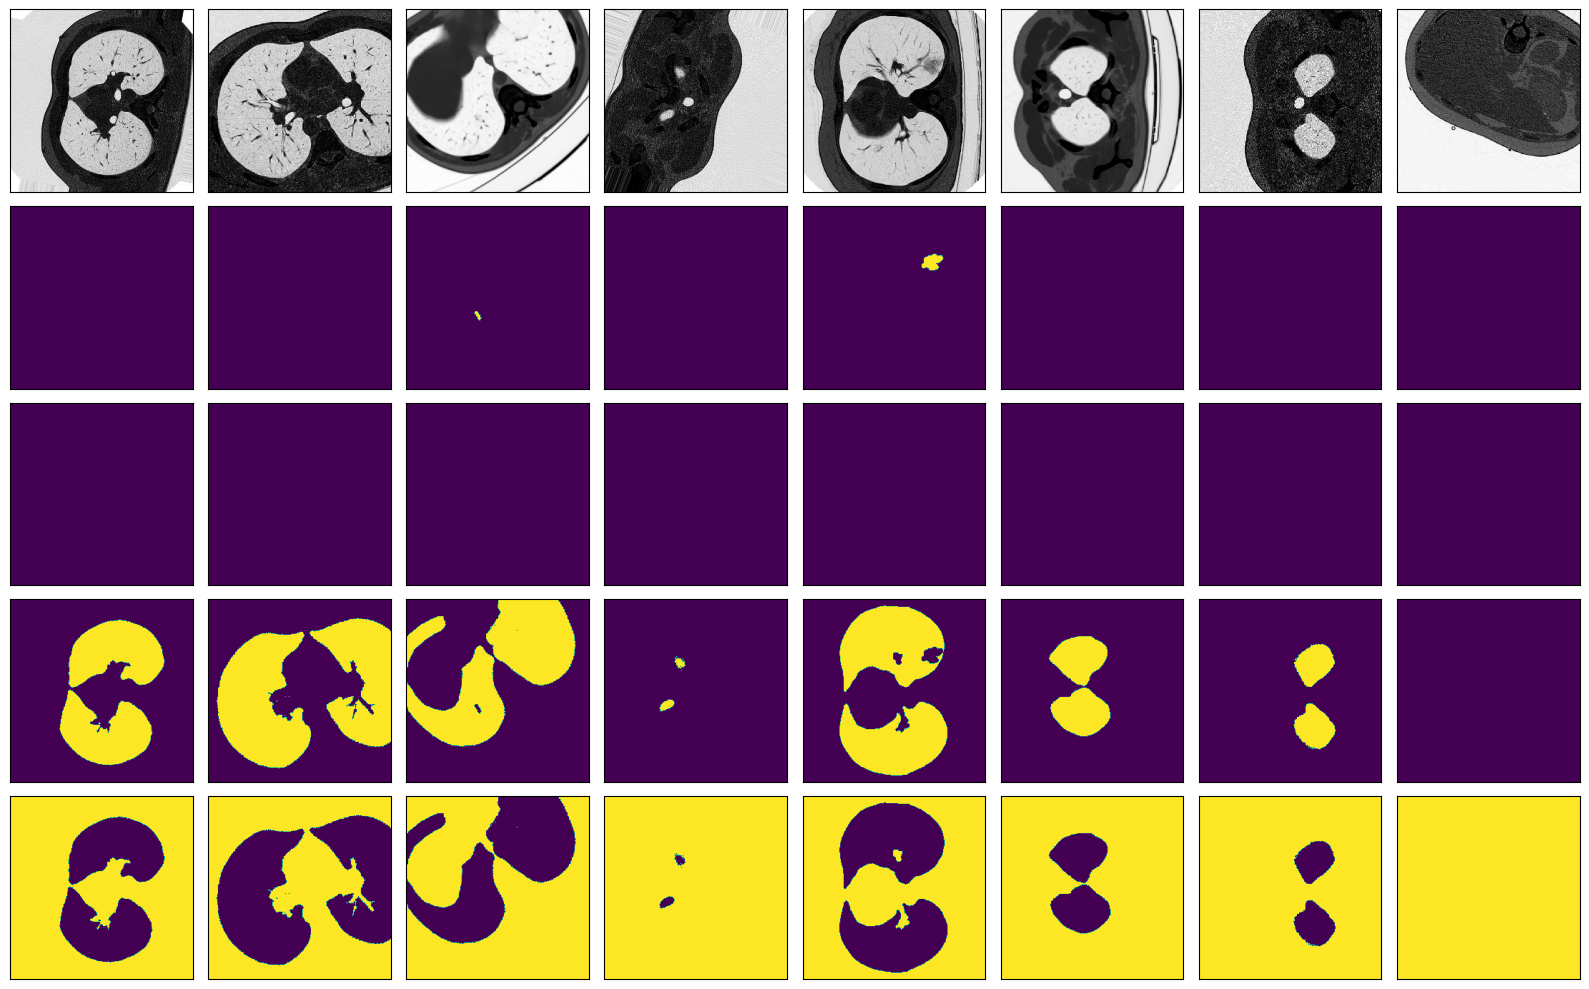

In [16]:
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a una representación one-hot (H, W, K),
    donde K es el número de clases y C representa el número de canales (1 o 3). Devuelve un tensor one-hot.
    """
    semantic_map = []
    for colour in palette:
        # Comprueba si cada píxel de la máscara coincide con un color en la paleta.
        equality = np.equal(mask, colour)
        # Genera un mapa binario por clase, donde se marcan los píxeles que coinciden con el color.
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    # Apila todos los mapas de clase y los convierte a tipo float32.
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convierte el mapa semántico a un tensor de PyTorch.
    return torch.from_numpy(semantic_map)

# Obtener el primer lote de datos del dataloader.
i, train_data = next(enumerate(train_dataloader))

# Convierte la máscara del dataset en un tensor one-hot usando la paleta de colores.
mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)

# Visualiza la imagen original y la máscara codificada en one-hot.
visualize(train_data[0].permute(0, 2, 3, 1), mask_hot_encoded)

In [17]:
# def pixel_accuracy(output, mask):
#     """
#     Calcula la precisión de los píxeles comparando la salida del modelo con la máscara real.
#     """
#     with torch.no_grad():
#         # Aplica softmax y luego toma la clase con mayor probabilidad.
#         output = torch.argmax(F.softmax(output, dim=1), dim=1)
#         # Compara los píxeles predichos con los reales.
#         correct = torch.eq(output, mask).int()
#         # Calcula la precisión como el ratio de píxeles correctos sobre el total.
#         accuracy = float(correct.sum()) / float(correct.numel())
#     return accuracy

In [18]:
def pixel_accuracy_per_class(output, mask):
    """
    Calcula la precisión solo para las clases 0 (ground glass) y 1 (consolidations).
    """
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        accuracy_per_class = []

        for clas in [0, 1]:  # Solo evaluamos ground glass (0) y consolidations (1)
            output_class = (output == clas).int()
            mask_class = (mask == clas).int()

            correct = torch.eq(output_class, mask_class).int()
            accuracy = float(correct.sum()) / float(mask_class.numel())
            accuracy_per_class.append(accuracy)
            
    return accuracy_per_class  # Devolver precisión por ground glass y consolidations


In [19]:
def dice_coefficient_per_class(pred_mask, mask, smooth=1e-6):
    """
    Calcula el coeficiente de Dice solo para las clases 0 (ground glass) y 1 (consolidations).
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in [0, 1]:  # Solo evaluamos ground glass (0) y consolidations (1)
            pred_mask_class = (pred_mask == clas).float()
            mask_class = (mask == clas).float()

            intersection = torch.sum(pred_mask_class * mask_class)
            dice = (2. * intersection + smooth) / (torch.sum(pred_mask_class) + torch.sum(mask_class) + smooth)
            dice_per_class.append(dice)
            
    return dice_per_class  # Devolver Dice Coefficient por ground glass y consolidations


In [20]:
# def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
#     """
#     Calcula el IoU medio para todas las clases. Es una métrica que mide la intersección sobre la unión
#     entre la predicción y la máscara real.
#     """
#     with torch.no_grad():
#         # Aplica softmax para obtener probabilidades, luego selecciona la clase más probable.
#         pred_mask = F.softmax(pred_mask, dim=1)
#         pred_mask = torch.argmax(pred_mask, dim=1)
#         pred_mask = pred_mask.contiguous().view(-1)
#         mask = mask.contiguous().view(-1)

#         iou_per_class = []
#         # Itera sobre cada clase para calcular IoU por clase.
#         for clas in range(0, n_classes):
#             true_class = pred_mask == clas
#             true_label = mask == clas

#             if true_label.long().sum().item() == 0:  # Si no hay píxeles para esta clase.
#                 iou_per_class.append(np.nan)
#             else:
#                 # Calcula la intersección y la unión.
#                 intersect = torch.logical_and(true_class, true_label).sum().float().item()
#                 union = torch.logical_or(true_class, true_label).sum().float().item()
#                 # Calcula el IoU usando intersección sobre unión.
#                 iou = (intersect + smooth) / (union + smooth)
#                 iou_per_class.append(iou)
#         # Devuelve la media de IoU por clase, ignorando NaN.
#         return np.nanmean(iou_per_class)

In [21]:
def mIoU_per_class(pred_mask, mask, smooth=1e-10):
    """
    Calcula el IoU solo para las clases 0 (ground glass) y 1 (consolidations).
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in [0, 1]:  # Solo evaluamos ground glass (0) y consolidations (1)
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
                
    return iou_per_class  # Devolver IoU por ground glass y consolidations


In [22]:
def iou(pred, gt):
    """
    Calcula el IoU entre la predicción y la verdad de terreno (ground truth).
    """
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))  # Intersección.
    u = float(np.sum(agg > 0))   # Unión.
    # Si no hay unión, IoU es 1, de lo contrario se calcula la fracción.
    if u == 0:
        result = 1
    else:
        result = i / u
    return result

In [23]:
# Definición del modelo U-Net usando EfficientNet como backbone. MOD JP
model = smp.Unet('efficientnet-b2', in_channels=1, encoder_weights='imagenet',
                 classes=4, activation=None, encoder_depth=5,
                 decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

In [24]:
# def get_lr(optimizer):
#     """
#     Devuelve la tasa de aprendizaje actual del optimizador.
#     """
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
#     """
#     Entrena el modelo a través de múltiples épocas. Monitorea las métricas como pérdida, IoU, y precisión.
#     Guarda el modelo si la pérdida de validación mejora.
#     """
#     train_losses = []
#     test_losses = []
#     val_iou = []; val_acc = []
#     train_iou = []; train_acc = []
#     lrs = []
#     min_loss = np.inf  # Mejor pérdida hasta el momento.
#     decrease = 1; not_improve = 0

#     model.to(device)
#     fit_time = time.time()

#     for e in range(epochs):
#         since = time.time()
#         running_loss = 0
#         iou_score = 0
#         accuracy = 0

#         model.train()  # Fase de entrenamiento.
#         for i, data in enumerate(tqdm(train_loader)):
#             image_tiles, mask_tiles = data
#             image = image_tiles.to(device); mask = mask_tiles.to(device)

#             # Forward pass.
#             output = model(image)
#             loss = criterion(output, mask)

#             # Cálculo de métricas.
#             iou_score += mIoU(output, mask)
#             accuracy += pixel_accuracy(output, mask)

#             # Backpropagation y optimización.
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             # Actualización de la tasa de aprendizaje.
#             lrs.append(get_lr(optimizer))
#             scheduler.step()

#             running_loss += loss.item()

#         else:  # Validación después de cada época.
#             model.eval()
#             test_loss = 0
#             test_accuracy = 0
#             val_iou_score = 0

#             with torch.no_grad():
#                 for i, data in enumerate(tqdm(val_loader)):
#                     image_tiles, mask_tiles = data
#                     image = image_tiles.to(device); mask = mask_tiles.to(device)
#                     output = model(image)

#                     # Métricas en la fase de validación.
#                     val_iou_score += mIoU(output, mask)
#                     test_accuracy += pixel_accuracy(output, mask)
#                     loss = criterion(output, mask)
#                     test_loss += loss.item()

#             # Almacena las pérdidas promedio de entrenamiento y validación.
#             train_losses.append(running_loss / len(train_loader))
#             test_losses.append(test_loss / len(val_loader))

#             # Guarda el modelo si la pérdida de validación mejora.
#             if min_loss > (test_loss / len(val_loader)):
#                 print(f'Loss Decreasing.. {min_loss:.3f} >> {(test_loss/len(val_loader)):.3f}')
#                 min_loss = (test_loss / len(val_loader))
#                 decrease += 1
#                 if decrease % 5 == 0:
#                     print('saving model...')
#                     torch.save(model, f'Unet_efficientnet_b2_mIoU-{val_iou_score/len(val_loader):.3f}.pt')

#             # Si la pérdida no mejora, cuenta cuántas veces no ha mejorado.
#             if (test_loss / len(val_loader)) > min_loss:
#                 not_improve += 1
#                 min_loss = (test_loss / len(val_loader))
#                 print(f'Loss Not Decrease for {not_improve} time')
#                 # Este hiperparametro lo podemos aumentar para ver si el modelo mejora despues de 7 veces que no decrementa el loss. A lo mejor decrementa despues de 7 iteraciones
#                 if not_improve == 7:
#                     print('Loss not decrease for 7 times, Stop Training')
#                     break

#             # Registro de IoU y precisión.
#             val_iou.append(val_iou_score / len(val_loader))
#             train_iou.append(iou_score / len(train_loader))
#             train_acc.append(accuracy / len(train_loader))
#             val_acc.append(test_accuracy / len(val_loader))
#             print(f"Epoch:{e+1}/{epochs}..",
#                   f"Train Loss: {running_loss/len(train_loader):.3f}..",
#                   f"Val Loss: {test_loss/len(val_loader):.3f}..",
#                   f"Train mIoU:{iou_score/len(train_loader):.3f}..",
#                   f"Val mIoU: {val_iou_score/len(val_loader):.3f}..",
#                   f"Train Acc:{accuracy/len(train_loader):.3f}..",
#                   f"Val Acc:{test_accuracy/len(val_loader):.3f}..",
#                   f"Time: {(time.time()-since)/60:.2f}m")

#     # Devuelve el historial de pérdidas, IoU, precisión y tasas de aprendizaje.
#     # Esto más que nada nos ayuda para ver cómo han ido cambiando nuestras variables
#     # con cada epoch de entrenamiento
#     history = {'train_loss' : train_losses, 'val_loss': test_losses,
#                'train_miou' :train_iou, 'val_miou':val_iou,
#                'train_acc' :train_acc, 'val_acc':val_acc,
#                'lrs': lrs}
#     print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
#     return history

In [25]:
# Asegurarte de que el modelo esté en el dispositivo correcto (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_miou': [], 'val_miou': [],
        'train_acc': [], 'val_acc': [],
        'train_dice': [], 'val_dice': []
    }

    for e in range(epochs):
        running_loss = 0
        iou_score_train = [0] * 2  # Solo ground glass y consolidations
        accuracy_train = [0] * 2
        dice_score_train = [0] * 2
        
        model.train()
        for i, data in enumerate(train_loader):
            image, mask = data
            image = image.to(device)
            mask = mask.to(device)

            output = model(image)
            loss = criterion(output, mask)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iou_per_class = mIoU_per_class(output, mask)
            accuracy_per_class = pixel_accuracy_per_class(output, mask)
            dice_per_class = dice_coefficient_per_class(output, mask)

            for j in range(2):
                iou_score_train[j] += iou_per_class[j]
                accuracy_train[j] += accuracy_per_class[j]
                dice_score_train[j] += dice_per_class[j]

        history['train_loss'].append(running_loss / len(train_loader))
        history['train_miou'].append([x / len(train_loader) for x in iou_score_train])
        history['train_acc'].append([x / len(train_loader) for x in accuracy_train])
        history['train_dice'].append([x / len(train_loader) for x in dice_score_train])

        val_loss = 0
        iou_score_val = [0] * 2
        accuracy_val = [0] * 2
        dice_score_val = [0] * 2

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                image, mask = data
                image = image.to(device)
                mask = mask.to(device)

                output = model(image)
                loss = criterion(output, mask)
                val_loss += loss.item()

                iou_per_class = mIoU_per_class(output, mask)
                accuracy_per_class = pixel_accuracy_per_class(output, mask)
                dice_per_class = dice_coefficient_per_class(output, mask)

                for j in range(2):
                    iou_score_val[j] += iou_per_class[j]
                    accuracy_val[j] += accuracy_per_class[j]
                    dice_score_val[j] += dice_per_class[j]

        history['val_loss'].append(val_loss / len(val_loader))
        history['val_miou'].append([x / len(val_loader) for x in iou_score_val])
        history['val_acc'].append([x / len(val_loader) for x in accuracy_val])
        history['val_dice'].append([x / len(val_loader) for x in dice_score_val])

        print(f"Epoch {e+1}/{epochs}..",
              f"Train Loss: {history['train_loss'][-1]:.3f}..",
              f"Val Loss: {history['val_loss'][-1]:.3f}..",
              f"Train IoU (ground glass, consolidations): {history['train_miou'][-1]}..",
              f"Val IoU (ground glass, consolidations): {history['val_miou'][-1]}..",
              f"Train Acc (ground glass, consolidations): {history['train_acc'][-1]}..",
              f"Val Acc (ground glass, consolidations): {history['val_acc'][-1]}..",
              f"Train Dice (ground glass, consolidations): {history['train_dice'][-1]}..",
              f"Val Dice (ground glass, consolidations): {history['val_dice'][-1]}")

    return history



In [26]:
# Valor máximo del learning rate
max_lr = 1e-3
# Número de epochs
epoch = 10
# Penalización de regularización (esto nos ayuda para evitar el overfitting)
weight_decay = 1e-4

# Función de pérdida. Elegimos CrossEntropy porque es la que comúnmente se usa para
# problemas de clasificación
criterion = nn.CrossEntropyLoss()

# Optimizador AdamW para agregarle el weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

# Scheduler para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.
# Se utiliza OneCycleLR, que ajusta el learning rate entre un valor bajo y el máximo especificado
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

# Aqui se entrena el modelo y guardamos el historial del mismo en una variable para graficar
# los resultados de las variables (loss, score, accuracy, etc) después.
# Le pasamos los conjuntos de train y validation como parámetros, así como la función de
# pérdida, el optimizador AdamW y el Scheduler.
history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

Epoch 1/10.. Train Loss: 1.052.. Val Loss: 1.116.. Train IoU (ground glass, consolidations): [0.03029389354814968, 0.003972074053910614].. Val IoU (ground glass, consolidations): [0.04011901062998518, 0.01699081630646463].. Train Acc (ground glass, consolidations): [0.954445339946924, 0.9158197556486808].. Val Acc (ground glass, consolidations): [0.9351832071940104, 0.9046573638916016].. Train Dice (ground glass, consolidations): [tensor(0.0585, device='cuda:0'), tensor(0.0079, device='cuda:0')].. Val Dice (ground glass, consolidations): [tensor(0.0771, device='cuda:0'), tensor(0.0334, device='cuda:0')]
Epoch 2/10.. Train Loss: 0.798.. Val Loss: 0.863.. Train IoU (ground glass, consolidations): [0.03235802700653162, 0.00442754592542971].. Val IoU (ground glass, consolidations): [0.03226913466385081, 0.018316227792606537].. Train Acc (ground glass, consolidations): [0.9646536607614365, 0.93957099284673].. Val Acc (ground glass, consolidations): [0.9426282246907552, 0.9319508870442709]..

In [27]:
# Guardamos el modelo en un archivo
torch.save(model, 'Unet-efficientnet.pt')

In [30]:
# Funciones para graficar los resultados del modelo entrenado
# Función para graficar la pérdida por epoch (Train vs Validation)
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_miou(history):
    epochs = len(history['train_miou'])

    plt.plot([history['train_miou'][e][0] for e in range(epochs)], label='train_ground_glass', marker='*')
    plt.plot([history['val_miou'][e][0] for e in range(epochs)], label='val_ground_glass', marker='*')
    plt.plot([history['train_miou'][e][1] for e in range(epochs)], label='train_consolidations', marker='*')
    plt.plot([history['val_miou'][e][1] for e in range(epochs)], label='val_consolidations', marker='*')

    plt.title('Mean IoU (ground glass vs consolidations)'); plt.ylabel('IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()



def plot_acc(history):
    epochs = len(history['train_acc'])

    plt.plot([history['train_acc'][e][0] for e in range(epochs)], label='train_ground_glass', marker='*')
    plt.plot([history['val_acc'][e][0] for e in range(epochs)], label='val_ground_glass', marker='*')
    plt.plot([history['train_acc'][e][1] for e in range(epochs)], label='train_consolidations', marker='*')
    plt.plot([history['val_acc'][e][1] for e in range(epochs)], label='val_consolidations', marker='*')

    plt.title('Accuracy (ground glass vs consolidations)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()



def plot_dice(history):
    epochs = len(history['train_dice'])

    # Mueve los tensores de GPU a CPU antes de graficar
    plt.plot([history['train_dice'][e][0].cpu().item() for e in range(epochs)], label='train_ground_glass', marker='*')
    plt.plot([history['val_dice'][e][0].cpu().item() for e in range(epochs)], label='val_ground_glass', marker='*')
    plt.plot([history['train_dice'][e][1].cpu().item() for e in range(epochs)], label='train_consolidations', marker='*')
    plt.plot([history['val_dice'][e][1].cpu().item() for e in range(epochs)], label='val_consolidations', marker='*')

    plt.title('Dice Coefficient (ground glass vs consolidations)')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()





# # Función para graficar el puntaje por epoch (Train vs Validation)
# def plot_score(history):
#     plt.plot(history['train_miou'], label='train_mIoU', marker='*')
#     plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
#     plt.title('Score per epoch'); plt.ylabel('mean IoU')
#     plt.xlabel('epoch')
#     plt.legend(), plt.grid()
#     plt.show()

# # Función para graficar la precisión por epoch (Train vs Validation)
# def plot_acc(history):
#     plt.plot(history['train_acc'], label='train_accuracy', marker='*')
#     plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
#     plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
#     plt.xlabel('epoch')
#     plt.legend(), plt.grid()
#     plt.show()

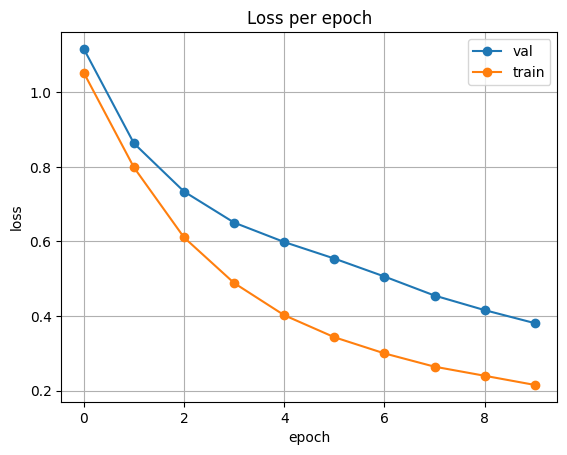

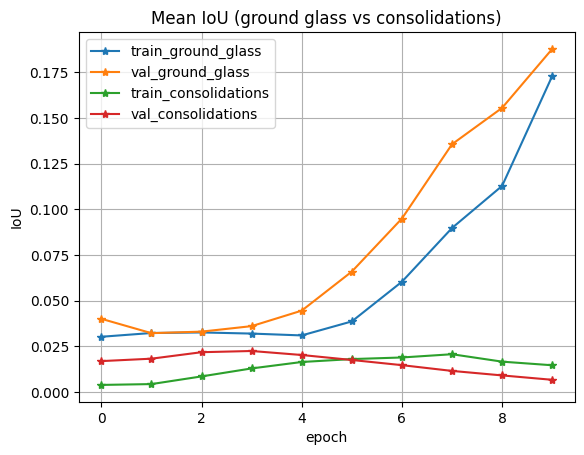

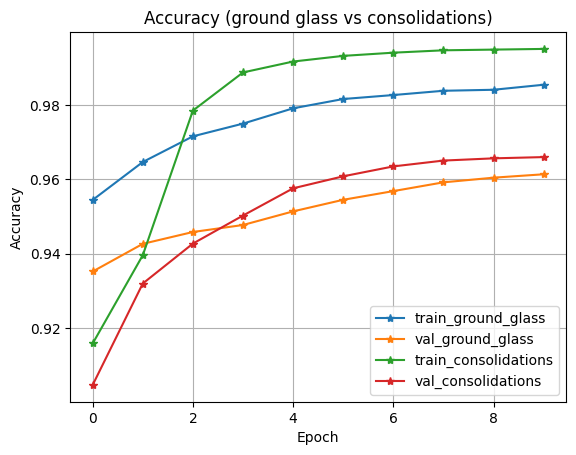

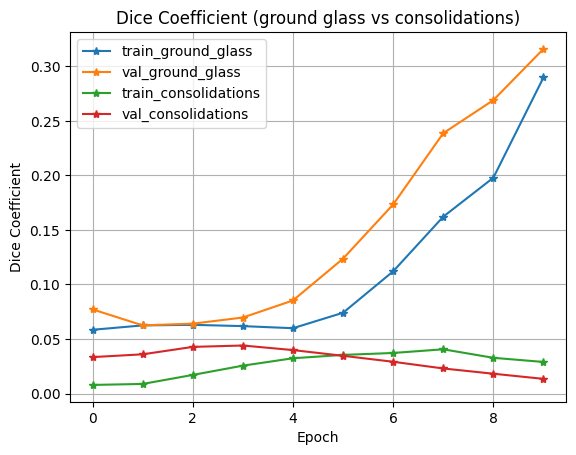

In [31]:
plot_loss(history)
# plot_score(history)
plot_miou(history)
plot_acc(history)
plot_dice(history)

# EVALUATION

In [32]:
# Función para predecir la máscara de una imagen y calcular la métrica mIoU
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    # Establecer el modelo en modo de evaluación
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    # Enviar el modelo y las imágenes a la GPU
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar el cálculo de los gradientes, ya que en esta fase no queremos
    # optimizar el modelo sino evaluarlo
    with torch.no_grad():

        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)

        # Obtener la predicción del modelo para la imagen dada
        output = model(image)
        # Obtener la forma de salida (batch size, canales, altura, anchura)
        a, b, c, d = output.shape
        # Calcular el puntaje de IoU medio (mIoU) para la predicción y la máscara real
        score = mIoU(output, mask)
        # Obtener la máscara predicha: argmax selecciona la clase con mayor probabilidad para cada pixel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha, el puntaje mIoU, y la salida original del modelo
    return masked, score, output.permute(0, 2, 3,1)

In [33]:
# Función para predecir la máscara de una imagen y calcular la precisión a nivel de píxel
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Establecer el modelo en modo de evaluación
    model.eval()

    # Mover el modelo, la imagen y la máscara al dispositivo (GPU si está disponible)
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar los gradientes
    with torch.no_grad():

        # Hacemos la predicción
        output = model(image)
        # Se calcula la precisión por píxel entre la máscara predicha y la real
        acc = pixel_accuracy(output, mask)
        # Se selecciona la clase con mayor probabilidad en cada píxel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha y la precisión por píxel
    return masked, acc

In [34]:
# Función para convertir una máscara de segmentación en un vector one-hot
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a (H, W, K), donde el último
    eje es un vector one-hot encoding. K es el número de clases.
    """
    semantic_map = []
    # Iterar sobre los colores en la paleta de clases
    for colour in palette:
        # Comparar cada píxel de la máscara con el color actual
        equality = np.equal(mask, colour)
        # Crear un mapa de clase donde coinciden los colores
        class_map = np.all(equality, axis=-1)
        # Agregar el mapa de clase a la lista
        semantic_map.append(class_map)
    # Apilar los mapas de clase en el último eje y convertirlos a float
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convertir el mapa semántico a un tensor de PyTorch
    return torch.from_numpy(semantic_map)

In [35]:
# Obtener un chunk de imágenes y máscaras del dataloader de validación
image, mask = next(iter(val_dataloader))
# Predecir la máscara
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
# Convertir la máscara real a one-phot encoding usando la paleta de colores definida
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

NameError: name 'mIoU' is not defined

In [ ]:
# Visualizar la imagen, el mapa semántico y la predicción del modelo
visualize(image, semantic_map, pred_batch=output)

# Amarillo es Verdadero Positivo (TP), rojo es Falso Positivo (FP), verde es Falso Negativo (FN)

In [30]:
# Función para calcular la puntuación mIoU (mean Intersection over Union) en un conjunto de prueba
def miou_score(model, test_set):
  # Lista para almacenar las puntuaciones de IoU
    score_iou = []
    # Iterar sobre el conjunto de prueba (test_set) utilizando tqdm para mostrar el progreso
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        # Predecir la máscara y calcular la puntuación mIoU usando la función predict_image_mask_miou
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        # Agregar la puntuación de mIoU a la lista
        score_iou.append(score)
    # Devolver los puntajes IoU
    return score_iou

In [ ]:
# Calcular la puntuación mIoU del modelo en el conjunto de validación
mob_miou = miou_score(model, val_dataloader)
mob_miou

In [32]:
# Eliminamos las imágenes y máscaras de entrenamiento para liberar memoria
del train_images
del train_masks

In [33]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    # Composición de transformaciones para la imagen: conversión a tensor y normalización
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # Aplicar las transformaciones a la imagen
    image = t(image)
    # Establecer el modo evaluacion para train
    model.eval()

    # Mover el modelo y la imagen al GPU
    model.to(device)
    image = image.to(device)

    # Desactivar el cálculo de los gradientes
    with torch.no_grad():
        # Realizar la predicción añadiendo una dimensión a la imagen para el batch
        output = model(torch.unsqueeze(image,1))
        # Aplicamos Softmax para obtener claramente las probabilidades de cada clase
        output = nn.Softmax(dim=1)(output)

    # Mover el resultado a la CPU y convertirlo a NumPy
    return output.permute(0, 2, 3, 1).cpu().numpy()


In [34]:
def visualize_final(image_batch, mask_batch=None, num_samples=8, hot_encode=True, alpha=0.7):
    """
    Visualiza las imágenes originales junto con la máscara superpuesta con una opacidad.
    """
    fig, ax = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

    for i in range(num_samples):
        ax_image = ax[i]

        # Mostrar la imagen original en escala de grises
        if hot_encode:
            ax_image.imshow(image_batch[i, :, :, 0], cmap='Greys')  
        else:
            ax_image.imshow(image_batch[i, :, :])

        # Si hay una máscara, hacer el overlap con la opacidad (alpha)
        if mask_batch is not None:
            # Usamos solo la primera clase de la máscara
            mask_to_show = mask_batch[i, :, :, 0]
            ax_image.imshow(mask_to_show, cmap='YlOrRd', alpha=alpha)

        # Eliminamos los ticks del eje
        ax_image.set_xticks([])
        ax_image.set_yticks([])

    # Ajustamos el layout para mejorar la visualización
    plt.tight_layout()
    plt.show()

In [ ]:
# Crear un batch de imágenes de prueba aplicando las transformaciones de validación
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
# Inicializar un array para almacenar las predicciones asignadno los valores para el tamaño
# del batch, altura, ancho y canales, respectivamente.
output = np.zeros((10,256,256,4))
# Bucle para realizar predicciones sobre cada imagen en el batch
for i in range(10):
    output[i] = test_predict(model, image_batch[i])
print(output.shape)
# Hacemos las máscaras de predicción de forma binaria (clase 0 o clase 1) con un threshold de 0.5
test_masks_prediction = output > 0.5
# Visualizar las imágenes de prueba junto con las máscaras de predicción
visualize_final(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [ ]:
import scipy
# Redimensionar las máscaras predichas a su tamaño original utilizando interpolación
# El factor de ampliación es 2x en las dimensiones espaciales (height, width)
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

In [37]:
import pandas as pd

# Convertir las máscaras redimensionadas a un archivo CSV
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())),
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1),
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')